In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

def generate_train_test_valid_data(data, labels, with_valid=False, bs=32):
    """
    Splits data into train, validation and test data and turns it into DataLoaders for efficient processing.
    """

    data = np.array(data)/255 # divided by 255 to get pixel values between 0 and 1
    labels = np.eye(len(np.unique(labels)))[labels] # 1-hot encoded vector

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True)

    # split train into train and valid data
    if with_valid:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

    # Converting training and testing set to use DataLoaders for easily iterating over batches
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    if with_valid:
        X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=bs, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=bs)
    
    if with_valid:
        valid_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=bs)
        return train_loader, test_loader, valid_loader
    
    else:
        return train_loader, test_loader
    
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

def plot_graph(epochs, noise_level, def_acc_hist, cust_acc_hist):
    x_range = range(1, epochs + 1)
    plt.plot(x_range, def_acc_hist, label=f"default filter")
    plt.plot(x_range, cust_acc_hist, label=f"custom filter")
    plt.title(f'Accuracy per Epoch ({noise_level}% noise)')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(range(1, epochs+1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    plt.show()

In [2]:
prewitt_x = np.array(([-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]))

prewitt_y = np.array(([1, 1, 1],
                      [0, 0, 0],
                      [-1, -1, -1]))
                      
sobel_x = np.array(([-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]))

sobel_y = np.array(([1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]))

#  creating a laplacian filter
laplacian = np.array(([-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, -1]))

krisch_nw = np.array(([-3, 5, 5],
                      [-3, 0, 5],
                      [-3, -3, -3]))

krisch_n = np.array(([-3, -3, 5],
                     [-3, 0, 5],
                     [-3, -3, 5]))

krisch_ne = np.array(([-3, -3, -3],
                      [-3, 0, 5],
                      [-3, 5, 5]))

krisch_e = np.array(([-3, -3, -3],
                     [-3, 0, -3],
                     [5, 5, 5]))

krisch_se = np.array(([-3, -3, -3],
                      [5, 0, -3],
                      [5, 5, -3]))

krisch_s = np.array(([5, -3, -3],
                     [5, 0, -3],
                     [5, -3, -3]))

krisch_sw = np.array(([5, 5, -3],
                      [5, 0, -3],
                      [-3, -3, -3]))

krisch_w = np.array(([5, 5, 5],
                     [-3, 0, -3],
                     [-3, -3, -3]))

In [11]:
from src.utils import fit
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class DefaultNet(nn.Module):
    def __init__(self, dim, num_classes=2):
        super(DefaultNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        
        # this part is to determine the shape of the first fully connected layer
        test_sample = torch.randn(dim, dim, dtype=torch.float32).view(-1,1,dim,dim)
        self._to_linear = None
        self.convs(test_sample)

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        
        return x
    
class CustomNet(nn.Module):
    def __init__(self, dim, num_classes=2, filters=None, bias=None, train_custom=False):
        super(CustomNet, self).__init__()

        self.conv0 = nn.Conv2d(1, len(filters), kernel_size=3, padding=1, bias=False)
        self.conv0.weight = nn.Parameter(filters)
        self.conv0.weight.requires_grad = False

        self.conv1 = nn.Conv2d(len(filters), 16, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)

        if bias is not None:
            self.conv1.bias = nn.Parameter(bias)
            
        test_sample = torch.randn(dim, dim, dtype=torch.float32).view(-1,1,dim,dim)
        self._to_linear = None
        self.convs(test_sample)

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def convs(self, x):
        x = F.relu(self.conv0(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        
        return x

dataset = np.load("data/32x32_ml_ppa_data_multi.npz")
data = dataset[dataset.files[4]]
noise = int(dataset.files[4].split("_")[1])
labels = dataset["labels"]

bs = 16
train_data, test_data = generate_train_test_valid_data(data, labels, bs=bs, with_valid=False)

epochs = 20
lr = 0.001

In [12]:
default_model = DefaultNet(32, num_classes=4)
default_opt = optim.Adam(default_model.parameters(), lr=lr)
loss_fun = nn.CrossEntropyLoss()
_, _, _, def_test_acc, _ = fit(default_model, epochs, default_opt, loss_fun, train_data, test_data, learn_plot=False)

In [17]:
my_custom_filters = np.array([[prewitt_x], [prewitt_y], [sobel_x], [sobel_y]], dtype=np.float32)
custom_model = CustomNet(32, num_classes=4, filters=torch.from_numpy(my_custom_filters))

custom_opt = optim.Adam(custom_model.parameters(), lr=lr)
loss_fun = nn.CrossEntropyLoss()
_, _, _, cust_test_acc, _ = fit(custom_model, epochs, custom_opt, loss_fun, train_data, test_data, learn_plot=False)

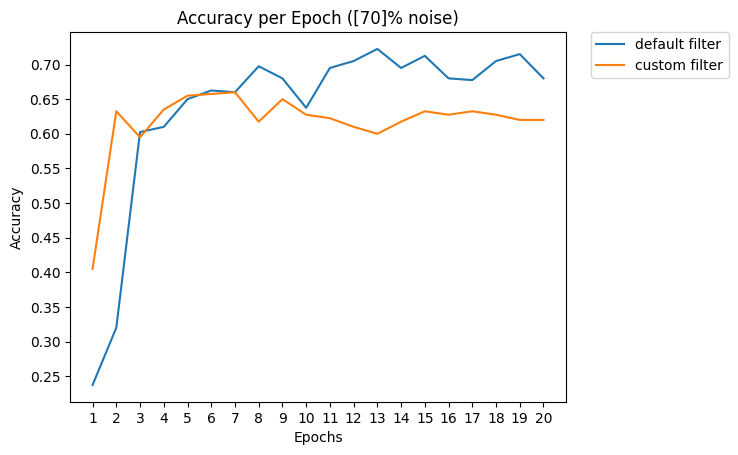

In [18]:
plot_graph(epochs, [noise], def_test_acc, cust_test_acc)